In [1]:
#importing relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, MultiPolygon, Polygon, LinearRing
import os
#importing the libraries ee (earth-engine) and gm (geemap)
import ee
import contextily as cx
import zipfile
import geemap as geemap


from pathlib import Path
from typing import Union
from datetime import datetime as dt
import geopandas as gpd



# Geographic Sampling: Buffet_Nasho irrigation

**Objective**: Generate a sampling frame of areas classified as ceopland, within each distance band of the Naico irrigation zone. Randomly sample n points in each distance band.  
**Rationale**:
    - Implememt a geographic regression discontinuity design.
    - Discontinuity is the border of the Naico irrigation area.
    - Running variable is the distance towards that border for each plot listed and sampled.
    - Here we're only interested in the outer-bands. Generate a proper sampling frame for plots to list in each outer band. This is a process of selecting relevant areas or pixels using a land cover classification for the areas of interest. 
        - Only cropland is included in the sampling frame
        - Only areas that have a slope of < X are included in the sampling frame. 
    - This file generates a set of coordinates or dots/stars which indicate which plot need to be listed in each band. 

## Relevant files & folders: 
    
***Data***: 
- "G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data"
  - Shapefiles and grids for each distance band. We're interested in Data\exterior_rasters which includes a folder with shapefiles for each distance band (300m, 600m, etc.). This has been uploaded to Google Earth Engine as assets. 


***Output***:
- This notebook decribing how the sampling frame was generated 
- G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\output for various graphs and figures
- G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\output\sample for the sampled of coordinates to list.  

## Approach
0. Upload relevant shapefiles to Google Earth Engine.

- Create a Sentinel-2 image composite for the regions of interest (each band) for the time frame that relevant crops are most visible (October-Jan 2022).  
- Create Dynamic world land cover composite for each distance band.
- Mask the Dynamic world land cover compisite so it only includes cropland.
        - Generate a little profile of each distance band (what is there? Built, water, etc.)
- Randomly sprawl a set of points in each distance-band. Number of points per band is: n ?
  



    
        
    

In [2]:
# Define utility functions 
def get_asset_list(parent):
    parent_asset = ee.data.getAsset(parent)
    parent_id = parent_asset['name']
    parent_type = parent_asset['type']
    asset_list = []
    child_assets = ee.data.listAssets({'parent': parent_id})['assets']
    for child_asset in child_assets:
        child_id = child_asset['name']
        child_type = child_asset['type']
        if child_type in ['FOLDER','IMAGE_COLLECTION']:
            # Recursively call the function to get child assets
            asset_list.extend(get_asset_list(child_id))
        else:
            asset_list.append(child_id)
    return asset_list
     
 
# create dictionary of laterite colors for visualisations. 
lt_colors={'latgrey':'#241F21',
           'latred': '#DA302C',
           'latorange':'#F27317',
           'latdarkgreen' : '#7DD9BA',
           'latgreen' : '#D0EED6',
           }

seed=42 #set a seed for reprodicibility


In [3]:
data_path=Path(r"G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data")
output_path=Path(r" G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\output")


0. Prepare and load shapefiles with exterior distance bands. 
- Looking at and visualising what the shapefiles with the various exterior bands look like. 
- Loading in shapefiles with exterior bands from g-drive, visualising  on top of a Humanitarian Open Streetmap Backdrop. 
- Shapefiles can be found here: G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data\exterior_boundaries



G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data\exterior_boundaries\ext_300m #1b9e77
   id  id_2      layer                   path  \
0   1     1  P1_circle  P1C.shp|layername=P1C   

                                            geometry  
0  MULTIPOLYGON (((30.69632 -2.10456, 30.69636 -2...  


C:\Users\linss\AppData\Local\Temp\ipykernel_17848\3264362967.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data\exterior_boundaries\ext_600m #d95f02
   id  id_2      layer                   path  \
0   1     1  P1_circle  P1C.shp|layername=P1C   

                                            geometry  
0  POLYGON ((30.69379 -2.10306, 30.69399 -2.10224...  


C:\Users\linss\AppData\Local\Temp\ipykernel_17848\3264362967.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data\exterior_boundaries\ext_900m #7570b3
   id  id_2      layer                   path  \
0   1     1  P1_circle  P1C.shp|layername=P1C   

                                            geometry  
0  MULTIPOLYGON (((30.69092 -2.10456, 30.69102 -2...  


C:\Users\linss\AppData\Local\Temp\ipykernel_17848\3264362967.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\linss\AppData\Local\Temp\ipykernel_17848\3264362967.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data\exterior_boundaries\ext_1200m #e7298a
   id  id_2      layer                   path  \
0   1     1  P1_circle  P1C.shp|layername=P1C   

                                            geometry  
0  POLYGON ((30.68856 -2.10223, 30.68960 -2.09902...  
G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data\exterior_boundaries\ext_1500m #66a61e
   id  id_2      layer                   path  \
0   1     1  P1_circle  P1C.shp|layername=P1C   

                                            geometry  
0  POLYGON ((30.68579 -2.10246, 30.68589 -2.10181...  


C:\Users\linss\AppData\Local\Temp\ipykernel_17848\3264362967.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


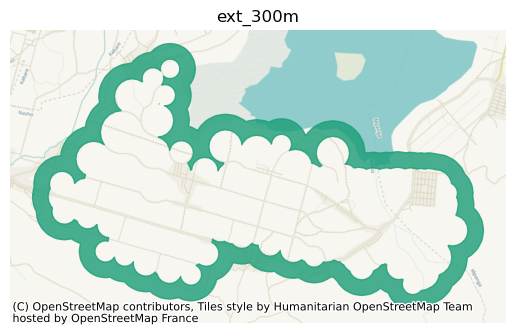

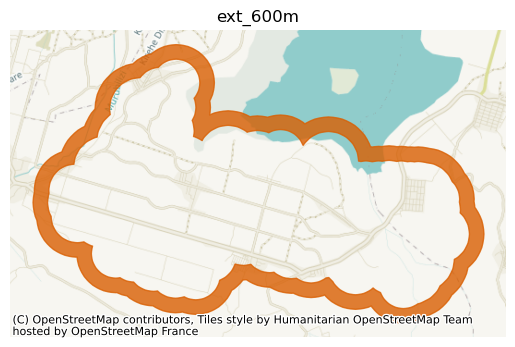

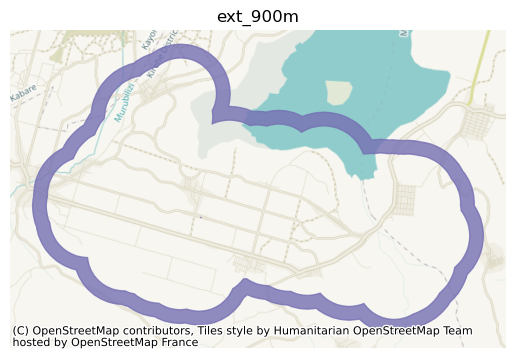

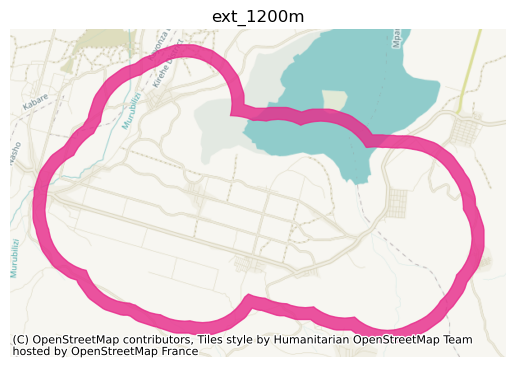

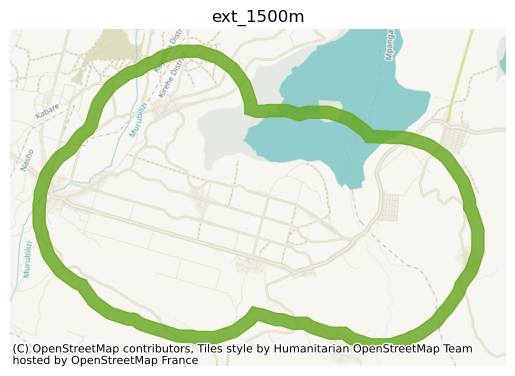

In [4]:
# prep and look at shapefiles. 

# exterior boundaries (ungridded) here: G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data\exterior_boundaries
color_list=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e']
boundaries_path=Path(r"G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data\exterior_boundaries")
#check what these shapefiles contain. 
for child, color in zip(Path(boundaries_path).iterdir(),color_list) :
    print(child, color)
    name=child.name
    gdf=gpd.read_file(child)
    print(gdf.head())
    fig, ax=plt.subplots(1,1)
    gdf.to_crs('EPSG:3857').plot(ax=ax, color=color, alpha=0.8, edgecolor=color)
    cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.HOT)
    ax.set_axis_off()
    ax.set_title(name)
    fig.show()
 



# for future reference: We've also gridded the exterior boundaries with fishnet grids. These can be fund here: G:\Shared drives\Laterite Projects - Ongoing - RWANDA\Buffet_Nasho_Irrigation\Sample\geographic_sampling\data\exterior_boundaries


- The shapefiles with boundaries look good. 
- I have uplaoded these manually to a Google Earth Engine account as assets in so-called  FeatureCollections for each distance band.
- These FeatureCollections serve as our main point of reference to filter out images from Google Earth Engine

## 0.1 Fire-up Google Earth Engine
- We need to login to and intialize Google Earth engine to work in this notebook. This is done below. 


In [5]:
# fire up GEE. 

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


- Now we check what we've uploaded to Google Earth Engine. 
- I've defined a little function to list all the assets in a specific google earth engine folder to check whether that upload has been done correctly. 
- These assets are printed below.

In [6]:

assets_list=get_asset_list("projects/ee-riklinssen/assets/exterior_boundaries")
print(assets_list)

###Wapor land cover data  for region of interest (circles are shown there). Perhaps we can work with these tiffs as well? 


#https://wapor.apps.fao.org/catalog/WAPOR_2/3/L3_LAK_LCC_D

['projects/ee-riklinssen/assets/exterior_boundaries/Exterior_1200m', 'projects/ee-riklinssen/assets/exterior_boundaries/Exterior_1500m', 'projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m', 'projects/ee-riklinssen/assets/exterior_boundaries/Exterior_600m', 'projects/ee-riklinssen/assets/exterior_boundaries/Exterior_900m']


In [7]:
## helper functions to create composites, mask the cropland, and sample points. 
def create_band_composite(band, dynamic_world):
    """
    Create a median composite image for a given band from the Dynamic World dataset.

    :param band: ee.FeatureCollection, the geographic band (region of interest) for which to create the composite.
    :param dynamic_world: ee.ImageCollection, the Dynamic World land cover dataset filtered by date.
    :return: ee.Image, the median composite image clipped to the specified band.
    """
    # Clip the Dynamic World dataset to the specified band
    clipped_dw = dynamic_world.map(lambda image: image.clip(band.geometry()))
    # Create a median composite of the clipped data
    composite = clipped_dw.median()
    return composite


def mask_cropland(composite):
    """
    Mask a composite image to include only cropland areas.

    :param composite: ee.Image, the composite image from which to mask non-cropland areas.
    :return: ee.Image, the masked image where only cropland areas are included.
    """
    # Select the 'label' band and create a mask where it equals 4 (cropland)
    cropland_mask = composite.select('label').eq(4)
    # Update the composite to only include cropland areas
    masked_composite = composite.updateMask(cropland_mask).select('label')
    return masked_composite




def sample_cropland(band, masked_image, num_samples, seed):
    """
    Sample the masked image for pixels classified as cropland within a specified band.

    :param band: An ee.FeatureCollection that defines the region to sample within.
    :param masked_image: An ee.Image that has been masked for cropland areas.
    :param num_samples: Integer, the number of pixels to sample within the band.
    :return: An ee.FeatureCollection containing the sampled points.
    """
    sampled_points = masked_image.sample(
        region=band.geometry(),
        scale=30,  # Adjust scale according to your data resolution
        numPixels=num_samples,
        seed=seed,  # Seed for reproducibility, change if needed
        geometries=True  # Set to True to get geometries
    )
    return sampled_points


# def extract_lat_lon(feature_collection):
#     """
#     Extract latitude and longitude from each feature in a FeatureCollection.

#     :param feature_collection: An ee.FeatureCollection of points.
#     :return: A list of dictionaries containing the latitude and longitude of each point.
#     """
#     # Function to extract lat, lon from a feature and put it in properties of a new feature
#     def get_coords(feature):
#         coords = ee.Feature(feature).geometry().coordinates()
#         return ee.Feature(None, {'latitude': coords.get(1), 'longitude': coords.get(0)})

#     # Use map to apply the get_coords function to each feature in the collection
#     lat_lon_list = feature_collection.map(get_coords).getInfo()
#     return lat_lon_list



def create_feature_collection(feature_collection):
    """
    Create a FeatureCollection from the coordinates of each feature in the input FeatureCollection.

    :param feature_collection: An ee.FeatureCollection of points.
    :return: An ee.FeatureCollection where each feature is a point with latitude and longitude properties.
    """
    def create_feature(feature):
        # Get the coordinates of the current feature
        coords = ee.Feature(feature).geometry().coordinates()
        # Create a new point feature with these coordinates
        point = ee.Geometry.Point([coords.get(0), coords.get(1)])
        return ee.Feature(point, {'longitude': coords.get(0), 'latitude': coords.get(1)})
    
    # Apply the create_feature function to each feature in the collection
    points_feature_collection = feature_collection.map(create_feature)
    return points_feature_collection



def ee_featurecollection_to_geopandas(feature_collection):
    """
    Convert an ee.FeatureCollection into a GeoPandas DataFrame.

    :param feature_collection: An ee.FeatureCollection
    :return: A GeoPandas DataFrame
    """
    # Convert ee.FeatureCollection to GeoJSON
    geojson = geemap.ee_to_geojson(feature_collection)
    
    # Convert GeoJSON to GeoPandas DataFrame
    gdf = gpd.GeoDataFrame.from_features(geojson)
    
    return gdf


# 1. Collect Dynamic World Imagary. 

We'll be using imagary from the Dynamic World dataset. 
Dynamic World is a collection of  images that have been run through a classification model. All images collected by the Sentinel 2 sattelite, and each pixel within that image is classified towards its most likely land cover. The Sentinel 2 sattelite orbits approximately every 10 ten days, meaning there's data on land cover for every 10 days, give or take some images that contain too many clouds. This results in a near-real time classification of land cover. 

Dynamic World classifies the probaility that each pixel is: 
'water',
'trees',
'grass',
'flooded_vegetation',
'crops',
'shrub_and_scrub',
'built',
'bare',
'snow_and_ice',


See: https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1 for a description of this data. 


To collect that data we first need to: 
- Specify the start and the end date of the image collection to create a collection of images.
- Generate a composite image. This is a combination of all images overlayed on top of eachoter within a certain date-range. 
- We're using Oct 2022 till January 2023 as this is the time of year when the relevant crops are in 'full bloom' and its easiest to observe from space what is cropland and what is classified as cropland, trees, bare land or other
- We 'clip' (i.e. exclude irrelevant areas to optimize the computing power) this composite to each distance band. 
- Each individual image gives the probability of each classification for each pixel. A pixel is a 10m by 10m sqaure. We thus know for each pixel and image what the probability is that there is for instance cropland or snow present on the ground. 
- Additionally the Dynamic World imagery also includes the label of the classification that has the highest probability for each pixel and each image. This shows the most likely classification of each pixel. 
- We take the median value of that most likely classification. That is the median across all images collected within the specific date range. 

The above is implemented in the function create_band_composite. 
The composite is then a single image where pixel values have been aggregated. 

For illustration, I've generated that composite for the 300m exterior band. 






In [8]:
#Generate start and enddates for imagecollection.
start_date = "2022-10-01" # Taking season oct 2022 
end_date = "2023-01-31" # till january 2023

#get out the imageCollection
dynamic_world = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterDate(start_date, end_date)

#create a composite/boil down to a single imagee (300m only). 

ext_300m_composite=create_band_composite(ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m'), dynamic_world)
ext_300m_composite

- This results in an Image with 10 bands (these are image bands, not distance-bands, see them as columns in a dataset). 

Here's that image visualised (300m outer distance band- only). 




In [9]:
Map = geemap.Map()
Map.centerObject(ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m'))

dwVisParams = {
  'min': 0,
  'max': 8,
  'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1']
}

Map.addLayer(ext_300m_composite.select('label'), dwVisParams, 'Label Band')
vis_params = {'color': 'DA302Cff', 'width': 5, 'lineType': 'dotted', 'fillColor': '0000000'}

Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World', position='topright')

Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

- We're only interested in those areas that are covered by cropland in orange. To sample some random points within these we first need to apply a mask. That is: select only those areas that are classified as cropland. 
- This is implemented in the function mask_cropland. This function returns another image where each pixel is classified as cropland True or cropland False. 
- I've visualised that masked image (cropland only) below as well. 



In [10]:
land_mask = mask_cropland(ext_300m_composite)  #select cropland only. Visualise and compare with composite above. 
land_mask

In [12]:

# Map = geemap.Map()
# Map.centerObject(ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m'))


# vis_params = {'min':0, 'max': 1, 'palette': ['#000000',  '#E49635']}
# Map.addLayer(land_mask, vis_params, 'cropland only')

# vis_params_ext_band = {'color': '#1b9e77', 'width': 2, 'lineType': 'dotted', 'fillColor': '0000000', 'alpha':0.8}
# Map.addLayer(ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m'), vis_params_ext_band, '300m exterior band', )


# #Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World', position='topleft')

# Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [171]:
# check what I've uploaded to GEE. 

#create a dictionary of bands

exterior_bands={
    '300m_ext':ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m'), 
    '600m_ext': ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_600m'),
    '900m_ext': ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_900m'),
    '1200m_ext': ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_1200m'),
    '1500m_ext': ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_1500m'),  
    } 





In [172]:

ext_300m_composite=create_band_composite(exterior_bands['300m_ext'], dynamic_world).select('label') #extracting the label image-band which is the label with the highest probability. 
land_mask = mask_cropland(ext_300m_composite)  #viusalised land_mask below. This seems ok. 

samples=sample_cropland(band=exterior_bands['300m_ext'], masked_image=land_mask, num_samples=250, seed=seed)


#extract lat and lon from the sampled points
points= create_feature_collection(samples)

#throw the sampled points into a geodataframe. 

points_gdf=ee_featurecollection_to_geopandas(points)
#only select those pixels classified as cropland in 'label'
#set a crs on that points geodataframe. 

points_gdf=points_gdf.set_crs(epsg=4326)


EEException: Collection query aborted after accumulating over 5000 elements.

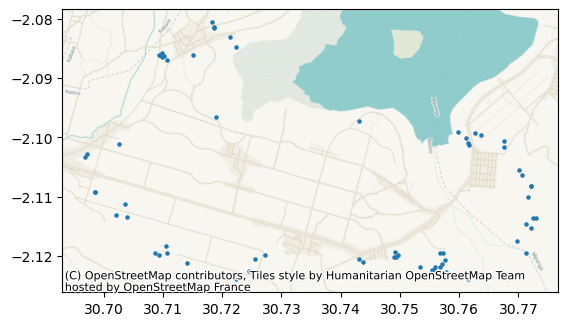

In [126]:

fig, ax=plt.subplots(1,1)
#plot the points 
points_gdf.plot(markersize=5, ax=ax)
#plot the boundaries of the band. 


cx.add_basemap(ax, crs='EPSG:4326')
fig.show()


#cx.add_basemap(ax, zoom=15, crs='EPSG:4326', source=cx.providers.CartoDB.Voyager)


In [90]:
#visualise the highest probability band, based on medians. 

# Method 2: Visualize the 'label' band
Map = geemap.Map()
Map.centerObject(ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m'))

dwVisParams = {
  'min': 0,
  'max': 8,
  'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1']
}

Map.addLayer(ext_300m_composite.select('label'), dwVisParams, 'Label Band')
vis_params = {'color': 'DA302Cff', 'width': 5, 'lineType': 'dotted', 'fillColor': '0000000'}

Map.addLayer(points)

Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World', position='topleft')

Map



Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [89]:
#visualise the land mask
Map = geemap.Map()
Map.centerObject(ee.FeatureCollection('projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m'))


vis_params = {'min':0, 'max': 1, 'palette': ['#808080',  '#E49635']}
Map.addLayer(land_mask,vis_params )


#Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World', position='topleft')

Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [11]:
# Create a Composite Image (Median Composite in this case)
dw_composite = dynamic_world.median()

# Define Function to Overlay and Sample Cropland
def sample_cropland(band, composite):
    # Filter Dynamic World data for the specified band
    dw_band = composite.clip(band)

    # Classify croplands
    croplands = dw_band.eq(1)  # Assuming '1' is the class value for croplands

    # Sample the pixels
    sampled_points = croplands.sample(**{
        'region': band.geometry(),
        'scale': 30,  # Adjust scale according to your data resolution
        'numPixels': 1000,  # Number of pixels to sample
        'seed': 1,  # Seed for reproducibility, change if needed
        'geometries': True  # Set to True to get geometries
    })

    return sampled_points

# Apply to Each Band
cropland_samples_band1 = sample_cropland(band1, dw_composite)
# Repeat for more bands as needed

# Export or Visualize Results
# Export to Drive example
task = ee.batch.Export.table.toDrive(**{
    'collection': cropland_samples_band1,
    'description': 'cropland_samples_band1',
    'fileFormat': 'CSV'
})
task.start()

['projects/ee-riklinssen/assets/exterior_boundaries/Exterior_1200m', 'projects/ee-riklinssen/assets/exterior_boundaries/Exterior_1500m', 'projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m', 'projects/ee-riklinssen/assets/exterior_boundaries/Exterior_600m', 'projects/ee-riklinssen/assets/exterior_boundaries/Exterior_900m']


In [12]:
threeh= exterior_bands['300m_ext']
sixh= exterior_bands['600m_ext']
nineh=exterior_bands['900m_ext']

Map = geemap.Map()
#Map.add_basemap('HYBRID')
Map.centerObject(nineh)

# Create a Sentinel-2 image composite
image = geemap.dynamic_world_s2(sixh, start_date, end_date)
vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000, 'gamma': 1.4, 'opacity':1}
Map.addLayer(image, vis_params, 'Sentinel-2 image')

#add the bands
#300meter exterior
vis_params = {'color': 'DA302Cff', 'width': 5, 'lineType': 'dotted', 'fillColor': '0000000'}
Map.addLayer(threeh, vis_params, '300m exterior band')


vis_params = {'color': '#7DD9BA', 'width': 5, 'lineType': 'dotted', 'fillColor': '0000000'}
Map.addLayer(sixh, vis_params, '600m exterior band')



vis_params = {'color': '#F27317', 'width': 5, 'lineType': 'dotted', 'fillColor': '0000000'}
Map.addLayer(nineh, vis_params, '900m exterior band')

Map


#Map.to_image(filename='\example_bands.png', monitor=1)



Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
#print(os.path.join(os.cwd(), 'my_map.png')
print(os.path.cwd())

In [ ]:
Map = geemap.Map(center=(40, -100), zoom=4)
Map


In [ ]:
## shapefiles are rasters get the boundaries only. 

In [ ]:
#create a list of folders with shapefiles. 
print(output_path)


In [ ]:
f='projects/ee-riklinssen/assets/exterior_boundaries/Exterior_300m'
#load in the dataset from GEE
grid = ee.FeatureCollection(f)
grid_geom = grid.geometry()

In [ ]:
# A Sentinel-2 surface reflectance image.
img = ee.Image('COPERNICUS/S2_SR/20210109T185751_20210109T185931_T10SEG')
true_color_viz = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0,
    'max': 2700,
    'gamma': 1.3,
}
display('Sentinel-2 image', img)
m = geemap.Map()
m.set_center(-122.36, 37.47, 10)
m.add_layer(img, true_color_viz, 'Sentinel-2 image')

# Create a Boolean land mask from the SWIR1 band water is value 0, land is 1.
land_mask = img.select('B11').gt(100)
display('Land mask', land_mask)
m.add_layer(land_mask, {'palette': ['blue', 'lightgreen']}, 'Land mask')

# Mask the land mask by itself pixel values equal to 0 (water) become invalid.
land_mask_masked = land_mask.selfMask()
display('Land mask, masked', land_mask_masked)
m.add_layer(land_mask_masked, {'palette': ['gold']}, 'Land mask, masked')
m


In [ ]:
geemap.map.add_layer()?


In [ ]:
boundaries_gdf

In [ ]:
print([ f for f in unioned.geoms])

In [ ]:
def extract_boundaries_from_shapefile(shapefile_path):
    # Read the shapefile into a GeoDataFrame
    gdf = gpd.read_file(shapefile_path)

    # Dissolve all polygons into a single MultiPolygon
    unioned = gdf.unary_union

    # Initialize an empty list for the boundary geometries
    boundary_geometries = []

    # Check if the unioned result is a MultiPolygon and handle accordingly
    if isinstance(unioned, MultiPolygon):
        # If it is a MultiPolygon, iterate over all polygons
        for polygon in unioned.geoms:  # use .geoms to iterate over individual Polygons
            # Add the outer boundary (exterior) of each polygon to the list
            boundary_geometries.append(polygon.exterior)
            # Add the inner boundaries (interiors) of each polygon to the list
            boundary_geometries.extend([interior for interior in polygon.interiors])
    elif isinstance(unioned, Polygon):
        # If the result is a single Polygon, just use its exterior and interiors directly
        boundary_geometries.append(unioned.exterior)
        boundary_geometries.extend([interior for interior in unioned.interiors])

    # Convert LINEARRINGS to Polygons if necessary
    for i, geom in enumerate(boundary_geometries):
        if isinstance(geom, LinearRing):
            boundary_geometries[i] = Polygon(geom)
    
    # Create a new GeoDataFrame from the boundary geometries
    boundaries_gdf = gpd.GeoDataFrame(geometry=boundary_geometries)
    
    return boundaries_gdf

# # Use the function with your shapefile
# fileloc = 'path_to_your_shapefile_directory/shapefile.shp'  # Update with the correct path to your shapefile
# boundaries_gdf = extract_boundaries_from_shapefile(fileloc)

# # Plot the result to confirm
# boundaries_gdf.plot()
